# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from IPython.display import display
from scipy.stats import itemfreq
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler

# Display all columns for convenience
pd.set_option('display.max_columns', None)

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
# Function definitions

def show_values_on_bars(axs, h_v="v", space=0.4):
    """Source: https://stackoverflow.com/a/56780852/9152905"""
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = round(p.get_height(), 2)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = round(p.get_width(), 2)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


def nans_to_list(nans):
    # Get NaNs
    nans = nans.tolist()
    # Clean string
    nans = [x.strip('[]') for x in nans]
    # Strings to lists
    nans = [x.split(',') if len(x) > 0 else [] for x in nans]
    # Number-strings to int, keep non-number strings
    nans = [[int(x) if x.lstrip('-').isdigit() else x for x in l] for l in nans]

    return nans


def replace_nans(data, nans):
    # Copy data to leave original data intact
    data = data.copy()
    
    # Load NaN values column wise and replace with np.nan
    for i, col_name in enumerate(data.columns):
        na = nans[i]

        data.loc[data[col_name].isin(na), col_name] = np.nan
        
    return data

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
with pd.option_context('display.max_columns', None):
    display(azdias.count())

AGER_TYP                 891221
ALTERSKATEGORIE_GROB     891221
ANREDE_KZ                891221
CJT_GESAMTTYP            886367
FINANZ_MINIMALIST        891221
FINANZ_SPARER            891221
FINANZ_VORSORGER         891221
FINANZ_ANLEGER           891221
FINANZ_UNAUFFAELLIGER    891221
FINANZ_HAUSBAUER         891221
FINANZTYP                891221
GEBURTSJAHR              891221
GFK_URLAUBERTYP          886367
GREEN_AVANTGARDE         891221
HEALTH_TYP               891221
LP_LEBENSPHASE_FEIN      886367
LP_LEBENSPHASE_GROB      886367
LP_FAMILIE_FEIN          886367
LP_FAMILIE_GROB          886367
LP_STATUS_FEIN           886367
LP_STATUS_GROB           886367
NATIONALITAET_KZ         891221
PRAEGENDE_JUGENDJAHRE    891221
RETOURTYP_BK_S           886367
SEMIO_SOZ                891221
SEMIO_FAM                891221
SEMIO_REL                891221
SEMIO_MAT                891221
SEMIO_VERT               891221
SEMIO_LUST               891221
                          ...  
OST_WEST

In [6]:
with pd.option_context('display.max_rows', None):
    display(feat_info)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
### Identify missing or unknown data values and convert them to NaNs. ###

In [7]:
# Check what types of NaN definitions we have to cover
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [8]:
# Convert NaN string inputs to lists
nans = nans_to_list(feat_info['missing_or_unknown'])
data = replace_nans(azdias, nans)

In [9]:
# Visually check results
data.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,NaN,2.0,5.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1979.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,NaN,1.0,5.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1957.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,NaN,1.0,3.0,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,1963.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,NaN,2.0,4.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Get NaN counts for each column
nan_count = data.isnull().sum()
nan_count_relative = nan_count / len(data) * 100

There are 61 columns with missing values.


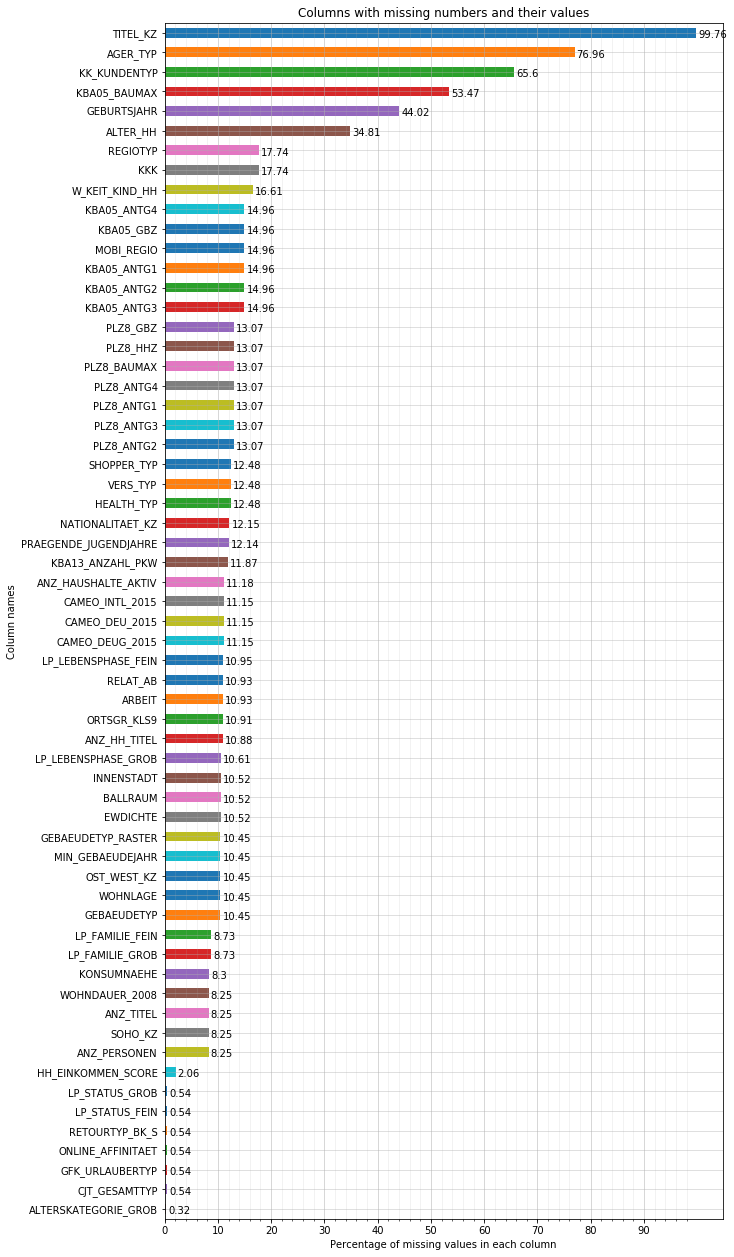

In [11]:
# Plot NaN coutns
fig, ax = plt.subplots(figsize=(10,22))
nan_count_relative[nan_count_relative > 0].sort_values(ascending=False).plot.barh(ax=ax);

# Same order as df
plt.gca().invert_yaxis()

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 100, 10)
minor_ticks = np.arange(0, 100, 2)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

# Add values
show_values_on_bars(ax, h_v='h')

# Add labels
plt.ylabel('Column names')
plt.xlabel('Percentage of missing values in each column')
plt.title('Columns with missing numbers and their values')

print("There are {} columns with missing values.".format(len(nan_count_relative[nan_count_relative > 0])))

In [14]:
# Investigate patterns in the amount of missing data in each column.

In [12]:
print('Features without missing data:', nan_count_relative[nan_count_relative == 0].count())

Features without missing data: 24


In [13]:
nan_count_relative.sort_values()

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

In [14]:
nan_greater_10 = nan_count_relative[nan_count_relative > 10].sort_values()
nan_greater_10

GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN      10.954859
CAMEO_INTL_2015          11.147852
CAMEO_DEU_2015           11.147852
CAMEO_DEUG_2015          11.147852
ANZ_HAUSHALTE_AKTIV      11.176913
KBA13_ANZAHL_PKW         11.871354
PRAEGENDE_JUGENDJAHRE    12.136608
NATIONALITAET_KZ         12.153551
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
PLZ8_ANTG4               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_ANTG1               13.073637
PLZ8_HHZ            

In [15]:
with pd.option_context('precision', 2):
    nan_greater_20 = nan_count_relative[nan_count_relative > 20]
    print(nan_greater_20.sort_values(ascending=False))

TITEL_KZ        99.76
AGER_TYP        76.96
KK_KUNDENTYP    65.60
KBA05_BAUMAX    53.47
GEBURTSJAHR     44.02
ALTER_HH        34.81
dtype: float64


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# The visual inspection shows that columns with an unusually high number of missing values have more than 30% missing values
nan_greater_30 = nan_count_relative[nan_count_relative > 30]
nan_greater_30 = nan_greater_30.index.tolist()
nan_greater_30

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [17]:
# Drop columns
data_uncleaned = data.copy()
data = data.drop(columns=nan_greater_30)

#### Discussion 1.1.2: Assess Missing Data in Each Column

**Patterns in missing values (apart from outliers)**

24 features (nearly one-third of the original dataset) have no missing data. Most other features have less than 15% missing data, some have up to 20% missing data and 6 have above 30% missing data (these are the outliers that will be dropped). Most columns with a similar amount of missing data belong to the same group. Some of the feature groups with missing values are described a little bit more below.

~10.45% group (5): "Building-level features" (GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, WOHNLAGE), with deviations in KONSUMNAEHE (8.3%), ANZ_HH_TITEL (10.88%, see **Outliers** for a short discussion), ANZ_HAUSHALTE_AKTIV (11.18%).

~10.51% group (3): A "Postalcode-level" group (BALLRAUM, INNENSTADT, EWDICHTE). All features in this group can be calculated based on the extent of the postal code, city regions, etc. Apparently some data was not available.

~13.07% group (7): A "Macrocell" group based on the postal code area. All features from this group with the same initials have the same amount of missing data suggesting that their values are all based on the same dataset.

~14.96% group (6): The "Microcell" group. These features are fairly similar to each other. Two exceptions: One member of the microcell group has way more missing values and is thus considered an outlier (KBA05_BAUMAX with 53.47%). And MOBI_REGIO which does not belong to the microcell but instead belongs to the "region" group and describes amount of movement. It is unclear why it has exactly the same percentage of missing values as the microcell features. This very much looks like something with the data is wrong here. Either the feature is assigned to the wrong group or data got mixed up between columns?

~ 16-17% group (3): One "Household" feature and two "Region" features: KKK (Purchasing power in region), REGIOTYP (Neighborhood typology), W_KEIT_KIND_HH (Likelihood of children in household). KKK and REGIOTYP essentially describe the same target variable. W_KEIT_KIND_HH is most likely a good proxy for the other two. All of the features are probably calculated from other metrics and due to their close relation would necessarily have the same amount of missing data.


**Outliers**

The dataset contains six columns with an unusually high number of missing values. While all other columns have less than 20% missing values, these six columns all have more than 30% of missing values. Thus 30% was chosen as threshold for dropping features.

Feature | Missing (%)
--- | ---
TITEL_KZ      |  99.76
AGER_TYP      |  76.96
KK_KUNDENTYP  |  65.60
KBA05_BAUMAX  |  53.47
GEBURTSJAHR   |  44.02
ALTER_HH      |  34.81

Microcell Features
* KBA05_BAUMAX (53.47%) (Most common building type within the microcell): Either a lot of respondents to the survey might not have had enough information on this topic or a supplemental data basis for the survey might have been lacking the necessary data.

Household Level Features
* KK_KUNDENTYP (65.60%) (Consumer pattern over past 12 months): This seems to be very specific. There could only be information available if the person is a customer (of whom???)
* ALTER_HH (34.81%) (Birthdate of head of household): This is surprising at first glance, because other personal features have way fewer missing values (around 10-12% missing values). So this feature has around 20%age points more missing values than comparable features. A possible explanation would be that the surveyed person did not know the birthdate of the head of the household out of their head.

Personal-level Features
* TITEL_KZ (99.76%) (Academic title flag): There is no category for not having an academic title. So everybody without a title of "Dr." and above will automatically be classified as NaN. That most of the values are not missing but rather the person just doesn't have a title can also be guessed by looking at **"ANZ_HH_TITEL"** (10.88% missing values which is only slightly above the median group-level amount of missing values of 10.45%). 10.88% missing values in this category suggests that the data for academic titles per person is decent and only lacking for around 10% of people. **Thus, the missing values for "TITEL_KZ" could probably be easily imputed!**
* GEBURTSJAHR (44.02%) (Year of birth): Even more surprising than the results for ALTER_HH. I do not have an explanation for this.
* AGER_TYP (76.96%) (Best-ager typology; What type of elderly... passive, cultural, experience-driven)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset before cleaning?
nan_row_count_uncleaned = data_uncleaned.isnull().sum(axis=1)

# How much data is missing in each row of the dataset after cleaning?
nan_row_count = data.isnull().sum(axis=1)

print('Percentage of missing data per row')
(nan_row_count / data.shape[1] * 100).head(15)

Percentage of missing data per row


0     54.430380
1      0.000000
2      0.000000
3      8.860759
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11    59.493671
12     7.594937
13    10.126582
14    59.493671
dtype: float64

In [19]:
# Total number of missing values
print('--- Total number of missing values ---')
print('Before:', nan_row_count_uncleaned.sum(),
      'After:', nan_row_count.sum(),
      'Ratio:', round(nan_row_count.sum()/nan_row_count_uncleaned.sum(), 2))

--- Total number of missing values ---
Before: 8373929 After: 5035304 Ratio: 0.6


In [20]:
# Number of rows with missing values
print('--- Number of rows with missing values ---')
print('Before:', nan_row_count_uncleaned[nan_row_count_uncleaned > 0].count(),
      'After:', nan_row_count[nan_row_count > 0].count(),
      'Ratio:', round(nan_row_count[nan_row_count > 0].count() / nan_row_count_uncleaned[nan_row_count_uncleaned > 0].count(), 2))

--- Number of rows with missing values ---
Before: 891078 After: 268012 Ratio: 0.3


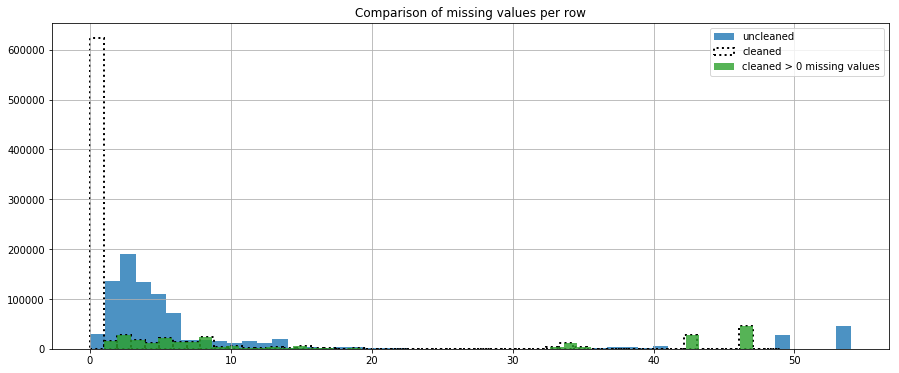

In [21]:
# Plot missing values per row before and after
fig, ax = plt.subplots(figsize=(15,6))
nan_row_count_uncleaned.hist(label='uncleaned', bins=50, ax=ax, alpha=0.8);
nan_row_count.hist(label='cleaned', bins=50, alpha=1, ls='dotted', lw=2, edgecolor='black', facecolor='None', ax=ax);
nan_row_count[nan_row_count > 0].hist(label='cleaned > 0 missing values', bins=50, ax=ax, alpha=0.8);

ax.set_title('Comparison of missing values per row')
plt.legend();

**Interpretation**

It's interesting that we were able to massively reduce the amount of rows with missing values by 70% by dropping six columns, although the total amount of missing values only dropped by 40%!

The histogram shows to distinct regions that are separated by a gap. One region lies between 0 and 20 rows with missing values, the other region lies between 30 and 50 rows with missing values.

So a good threshold to separate both regions should lie between 20 and 30 rows with missing values.

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
data_below_30 = data[nan_row_count < 30]
data_above_30 = data[nan_row_count > 30]
print('Below 30:', data_below_30.shape[0], 'Above 30:', data_above_30.shape[0])

Below 30: 798061 Above 30: 93154


In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Columns with no or few missing values
nan_count_relative[nan_count_relative < 5].sort_values(ascending=False)

HH_EINKOMMEN_SCORE       2.058749
ONLINE_AFFINITAET        0.544646
CJT_GESAMTTYP            0.544646
GFK_URLAUBERTYP          0.544646
LP_STATUS_FEIN           0.544646
LP_STATUS_GROB           0.544646
RETOURTYP_BK_S           0.544646
ALTERSKATEGORIE_GROB     0.323264
SEMIO_RAT                0.000000
SEMIO_KULT               0.000000
ANREDE_KZ                0.000000
ZABEOTYP                 0.000000
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
SEMIO_TRADV              0.000000
GREEN_AVANTGARDE         0.000000
SEMIO_PFLICHT            0.000000
SEMIO_KAEM               0.000000
SEMIO_DOM                0.000000
SEMIO_KRIT               0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST    

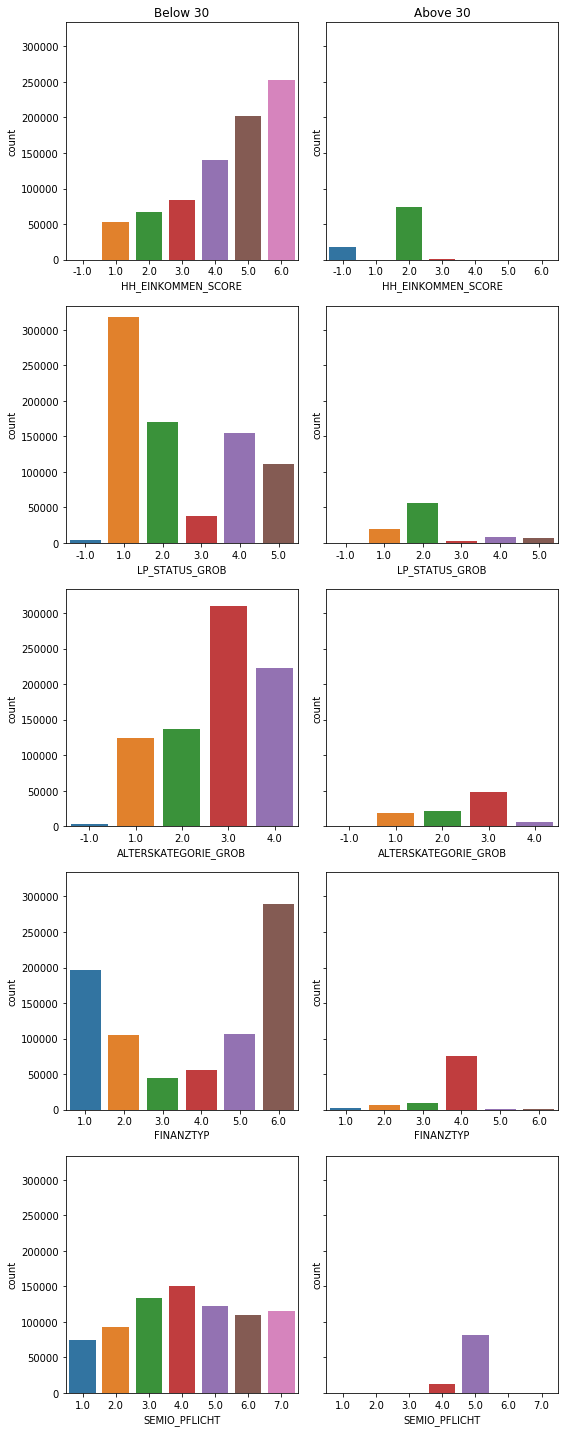

In [24]:
cols_selection_below_5 = ['HH_EINKOMMEN_SCORE', # 2.06
                          'LP_STATUS_GROB', # 0.54
                          'ALTERSKATEGORIE_GROB', # 0.32
                          'FINANZTYP', # 0.0
                          'SEMIO_PFLICHT'] # 0.0

tmp = data.fillna(-1)
tmp_below_30 = tmp[nan_row_count < 30]
tmp_above_30 = tmp[nan_row_count > 30]

# Create subplots
fig, axs = plt.subplots(ncols=2, nrows=len(cols_selection_below_5), figsize=(8,20), sharey=True)

# Draw two plots per column
for i, col in enumerate(cols_selection_below_5):
    # Easier access to correct axis
    ax0 = axs[i][0]
    ax1 = axs[i][1]
    
    # Draw plots for column
    order = sorted(tmp[col].unique().tolist())
    sns.countplot(x=col, data=tmp_below_30, ax=ax0, order=order)
    sns.countplot(x=col, data=tmp_above_30, ax=ax1, order=order)
    
# Set title
axs[0][0].set_title('Below 30')
axs[0][1].set_title('Above 30')

plt.tight_layout()

# Delete variables that are no longer needed
del tmp, tmp_below_30, tmp_above_30

#### Discussion 1.1.3: Assess Missing Data in Each Row

Rows with more than 30 missing values seem to be highly skewed towards one category whereas rows with less than 30 missing values seem to be more or less follow a normal distribution.

In [25]:
# Continue with a subset of the data with few or no missing values
data_uncleaned_rows = data.copy()
data = data[nan_row_count < 30]

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cols_cat = feat_info['attribute'][feat_info['type'] == 'categorical']
cols_cat = cols_cat[cols_cat.isin(data)]

cols_categorical_binary = [col for col in cols_cat
                           if data[col].nunique() == 2]

cols_categorical_multi = [col for col in cols_cat
                          if data[col].nunique() > 2]

print('--- Binary ---')
for col in cols_categorical_binary:
    print(col, data[col].unique())

print('\n--- Multicategorical ---')
for col in cols_categorical_multi:
    print(col, data[col].unique())

--- Binary ---
ANREDE_KZ [ 2.  1.]
GREEN_AVANTGARDE [ 0.  1.]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']

--- Multicategorical ---
CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP [ 1.  6.  5.  2.  4.  3.]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [  1.   3.   2.  nan]
SHOPPER_TYP [  3.   2.   1.   0.  nan]
ZABEOTYP [ 5.  3.  4.  1.  6.  2.]
GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '

In [28]:
# Keep a snapshot of the data before changing
data_cleaned_categorical = data.copy()

# Re-encode categorical variable(s) to be kept in the analysis.
data['OST_WEST_KZ'] = LabelEncoder().fit_transform(data['OST_WEST_KZ'])
data = data.drop(columns=cols_categorical_multi)

print(f'Dropped {len(cols_categorical_multi)} features:', cols_categorical_multi)
print(f'{data.shape[1]} features left in dataset')

Dropped 13 features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
66 features left in dataset


#### Discussion 1.2.1: Re-Encode Categorical Features

The following steps were performed:
1. Make a list of categorical columns present in the dataset
1. Based on this create two lists for the different type of categorical columns: binary and multicategorical
1. Examine the values for binary and multicategorical columns
1. Find binary columns with non-binary values
1. Re-encode binary column OST_WEST_KZ with non-binary values ('W', 'O') to binary
1. Drop multicategorical columns because there will still be enough columns in the dataset and interpretation and analysis will be much easier this way

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# List mixed columns in the dataset
cols_mixed = feat_info[feat_info['type'] == 'mixed']['attribute']
cols_mixed = cols_mixed[cols_mixed.isin(data)]
cols_mixed

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
data['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

Missing data PRAEGENDE_JUGENDJAHRE: 3.60%


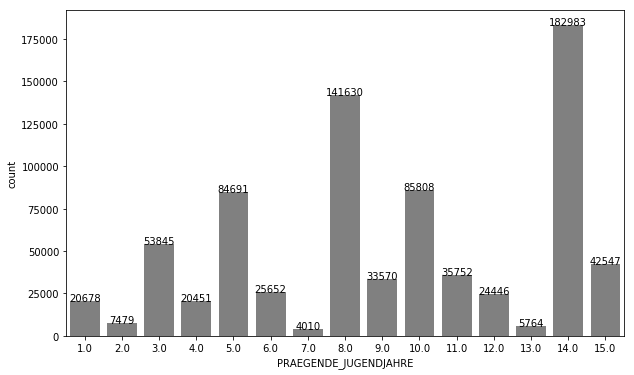

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=data, x='PRAEGENDE_JUGENDJAHRE', color='grey', ax=ax);
show_values_on_bars(ax, h_v='v')

print(f'Missing data PRAEGENDE_JUGENDJAHRE: {data["PRAEGENDE_JUGENDJAHRE"].isnull().sum() / len(data) * 100:.2f}%')

**"PRAEGENDE_JUGENDJAHRE"**
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Mapping
* decade = 1: 40s, 2: 50s, 3: 60s, 4: 70s, 5: 80s, 6: 90s -> new variable "PJ_DECADE"
* movement = 1: Mainstream, 2: Avantgarde -> new variable "PJ_MOVEMENT"

In [32]:
decade_mapping = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
movement_mapping = {1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 9: 2, 10: 1, 11: 2, 12: 1, 13: 2, 14: 1, 15: 2}

In [33]:
# Engineering new variables and dropping the old
data['PJ_DECADE'] = data['PRAEGENDE_JUGENDJAHRE'].astype(np.float).map(decade_mapping)
data['PJ_MOVEMENT'] = data['PRAEGENDE_JUGENDJAHRE'].astype(np.float).map(movement_mapping)
data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,NaN,NaN,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,32.0,10.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,8.0,2.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0


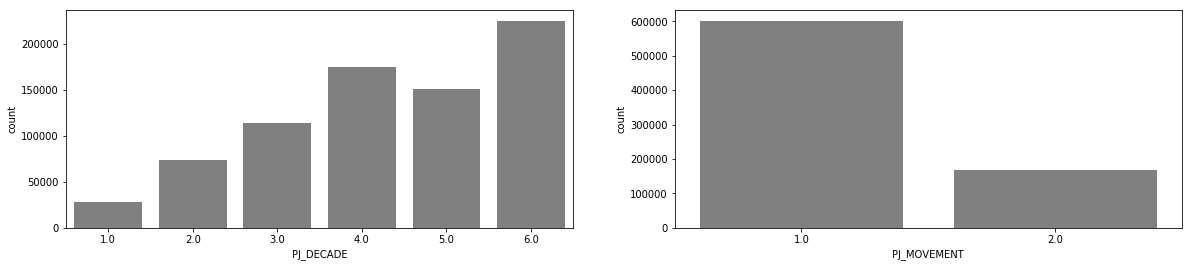

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(20,4))
sns.countplot(data=data, x='PJ_DECADE', color='grey', ax=ax[0])
sns.countplot(data=data, x='PJ_MOVEMENT', color='grey', ax=ax[1]);

['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
Missing data CAMEO_INTL_2015: 0.78%


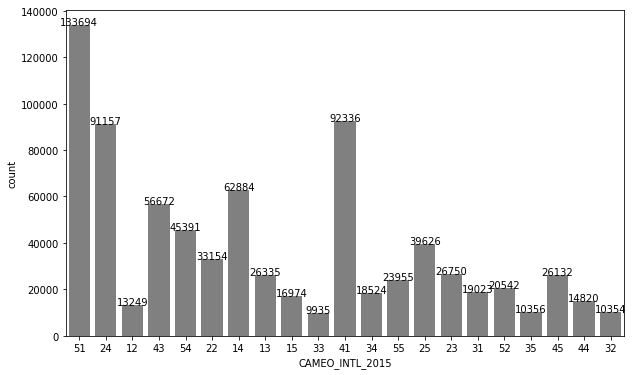

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(data['CAMEO_INTL_2015'].unique())
print(f'Missing data CAMEO_INTL_2015: {data["CAMEO_INTL_2015"].isnull().sum() / len(data) * 100:.2f}%')

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=data, x='CAMEO_INTL_2015', color='grey', ax=ax);
show_values_on_bars(ax, h_v='v')

**CAMEO_INTL_2015**
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Mapping
* wealth: new class is the first digit of the two-digit code -> new variable "CI_WEALTH"
* life stage: new class is the second digit of the two-digit code -> new variable "CI_LIFESTAGE"

In [36]:
wealth_mapping = {11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 41: 4, 42: 4, 43: 4, 44: 4, 45: 4, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5}
lifestage_mapping = {11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 21: 1, 22: 2, 23: 3, 24: 4, 25: 5, 31: 1, 32: 2, 33: 3, 34: 4, 35: 5, 41: 1, 42: 2, 43: 3, 44: 4, 45: 5, 51: 1, 52: 2, 53: 3, 54: 4, 55: 5}

In [37]:
# Engineering new variables and dropping the old
data['CI_WEALTH'] = data['CAMEO_INTL_2015'].astype(np.float).map(wealth_mapping)
data['CI_LIFESTAGE'] = data['CAMEO_INTL_2015'].astype(np.float).map(lifestage_mapping)
data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT,CI_WEALTH,CI_LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,NaN,NaN,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,32.0,10.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,8.0,2.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


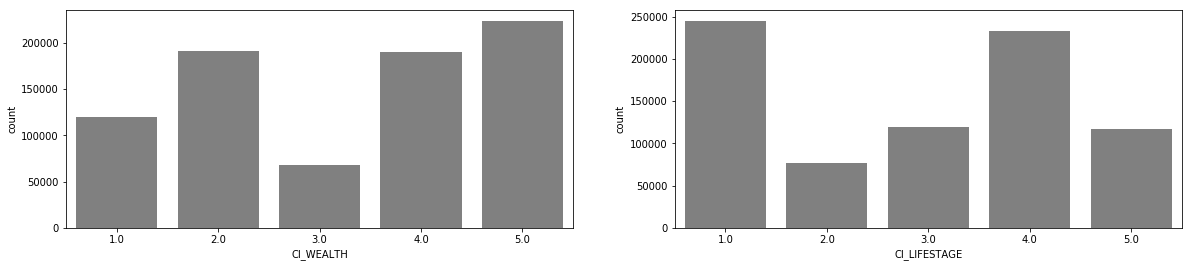

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(20,4))
sns.countplot(data=data, x='CI_WEALTH', color='grey', ax=ax[0])
sns.countplot(data=data, x='CI_LIFESTAGE', color='grey', ax=ax[1]);

In [39]:
# Drop columns that are no longer needed or were not "fixed"
data = data.drop(columns=cols_mixed)
data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT,CI_WEALTH,CI_LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

**PRAEGENDE_JUGENDJAHRE**

The category with the most values is 14:"90s - digital media kids (Mainstream, E+W)" with 182983 values. Three categories have very low representation 2:"40s - reconstruction years (Avantgarde, E+W)" with 7479, 7:"opponents to the building of the Wall (Avantgarde, E)" with 4010 and 13:"80s - Swords into ploughshares (Avantgarde, E)" with 5764. A visual inspection after feature engineering reveals that the "Avantgarde" movement and the "40s" generation are underrepresented.

**CAMEO_INTL_2015**

The three categories with the fewest values (9935, 10354, 10356) all belong to the same category of wealth: "Comfortable Households". This category is right in the middle of the wealth spectrum and seems to be underrepresented or maybe it's really the smallest category. A visual inspection after feature engineering confirms that this category is the smallest one.

**Feature Engineering**

Processing steps
1. Creation of mapping dicts
1. Converting mixed data to floats
1. Using the map-function from pandas to assign new values to existing data based on the mapping dicts
1. Creation of new columns for the mapped data
1. Deletion of old columns that were used for the mapping

Columns created
* PJ_DECADE
* PJ_MOVEMENT
* CI_WEALTH
* CI_LIFESTAGE

Columns dropped
* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015
* LP_LEBENSPHASE_FEIN
* LP_LEBENSPHASE_GROB
* WOHNLAGE
* PLZ8_BAUMAX

**Justification for dropping columns**

Two of the columns were substituted by four new ones. There are still enough features in the dataset that account for similar aspects as the other dropped features. All in all the analysis is a little easier and more straightforward with less features. In a later iteration more of the excluded features could be prepared and included. Usually it's better to aim for decent and quick results instead of preparing everything perfectly from the start.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print(data.shape)
print(data.columns)
print(feat_info[feat_info['attribute'].isin(data)][['attribute', 'type', ]])

(798061, 64)
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',


In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [41]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Make nodata values uniform
    nans = nans_to_list(feat_info['missing_or_unknown'])
    data = replace_nans(df, nans)
    
    # Get columns with more than 30% missing values
    nan_count = data.isnull().sum()
    nan_count_relative = nan_count / len(data) * 100
    nan_greater_30 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    # Drop columns with more than 30% missing values
    data = data.drop(columns=nan_greater_30)
    
    # Get number of missing values per row
    nan_row_count = data.isnull().sum(axis=1)
    # Only keep rows with less than 30 missing values
    data = data[nan_row_count < 30]
    
    # Get lists of different types of categorical columns
    cols_cat = feat_info['attribute'][feat_info['type'] == 'categorical']
    cols_cat = cols_cat[cols_cat.isin(data)]
    cols_categorical_binary = [col for col in cols_cat if data[col].nunique() == 2]
    cols_categorical_multi = [col for col in cols_cat if data[col].nunique() > 2]
    cols_mixed = feat_info[feat_info['type'] == 'mixed']['attribute']
    cols_mixed = cols_mixed[cols_mixed.isin(data)]
    # Transform binary column with non-binary values
    data['OST_WEST_KZ'] = LabelEncoder().fit_transform(data['OST_WEST_KZ'])
    # Drop untransformed multicategorical data
    data = data.drop(columns=cols_categorical_multi)
    
    # Dcitionary mappings for columns with mixed data
    # PRAEGENDE_JUGENDJAHRE
    decade_mapping = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5,
                      11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
    movement_mapping = {1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 9: 2, 10: 1,
                        11: 2, 12: 1, 13: 2, 14: 1, 15: 2}
    # CAMEO_INTL_2015
    wealth_mapping = {11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 21: 2, 22: 2, 23: 2, 24: 2,
                      25: 2, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 41: 4, 42: 4, 43: 4,
                      44: 4, 45: 4, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5}
    lifestage_mapping = {11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 21: 1, 22: 2, 23: 3,
                         24: 4, 25: 5, 31: 1, 32: 2, 33: 3, 34: 4, 35: 5, 41: 1,
                         42: 2, 43: 3, 44: 4, 45: 5, 51: 1, 52: 2, 53: 3, 54: 4, 55: 5}
    
    # Feature engineering for columns with mixed data
    data['PJ_DECADE'] = data['PRAEGENDE_JUGENDJAHRE'].astype(np.float).map(decade_mapping)
    data['PJ_MOVEMENT'] = data['PRAEGENDE_JUGENDJAHRE'].astype(np.float).map(movement_mapping)
    data['CI_WEALTH'] = data['CAMEO_INTL_2015'].astype(np.float).map(wealth_mapping)
    data['CI_LIFESTAGE'] = data['CAMEO_INTL_2015'].astype(np.float).map(lifestage_mapping)
    # Drop all mixed data columns
    data = data.drop(columns=cols_mixed)
    
    return data

In [42]:
# Sanity check
%time df = clean_data(azdias)
df.head()

CPU times: user 16.4 s, sys: 21.7 s, total: 38.1 s
Wall time: 2min 9s


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT,CI_WEALTH,CI_LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [43]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Percentage of missing values per column
round((data.isnull().mean(axis=0) * 100).sort_values(ascending=False)[:21], 2)

REGIOTYP               8.13
KKK                    8.13
W_KEIT_KIND_HH         7.43
KBA05_ANTG4            5.03
KBA05_ANTG2            5.03
KBA05_ANTG3            5.03
MOBI_REGIO             5.03
KBA05_ANTG1            5.03
KBA05_GBZ              5.03
HEALTH_TYP             4.60
VERS_TYP               4.60
PJ_DECADE              3.60
PJ_MOVEMENT            3.60
PLZ8_ANTG2             2.93
PLZ8_ANTG1             2.93
PLZ8_ANTG4             2.93
PLZ8_HHZ               2.93
PLZ8_GBZ               2.93
PLZ8_ANTG3             2.93
KBA13_ANZAHL_PKW       1.58
ANZ_HAUSHALTE_AKTIV    0.81
dtype: float64

In [44]:
# How much does the missing data influence our dataset?
rows_with_nans = data.isnull().mean(axis=1) * 100

print(f'Rows with missing values: {round(rows_with_nans[rows_with_nans > 0].shape[0] / data.shape[0]  * 100, 2)}%')
print(f'Missing values in total: {round(data.isnull().sum().sum() / np.product(data.shape) * 100, 2)}%')

Rows with missing values: 21.91%
Missing values in total: 1.49%


In [46]:
# Impute missing values
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)

data_imputed = data.copy()
data_imputed[data_imputed.columns] = imputer.fit_transform(data)

In [47]:
# Sanity check
display(data_imputed.tail())
display(data.tail())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT,CI_WEALTH,CI_LIFESTAGE
891216,3.0,2.0,1.0,4.0,2.0,5.0,4.0,4.0,0.0,3.0,3.0,2.0,1.0,3.0,3.0,2.0,1.0,6.0,3.0,4.0,4.0,7.0,5.0,4.0,2.0,0.0,1.0,1.0,0.0,4.0,3.0,4.0,15.0,0.0,3.0,1992.0,1.0,2.0,1.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,2.0,3.0,3.0,5.0,3.0,6.0,1.0,4.0,1.0
891217,2.0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,0.0,2.0,5.0,4.0,4.0,7.0,5.0,4.0,7.0,7.0,4.0,4.0,4.0,4.0,4.0,6.0,2.0,0.0,2.0,1.0,0.0,6.0,6.0,9.0,11.0,0.0,1.0,1992.0,1.0,0.0,0.0,1.0,1.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,5.0,3.0,4.0,6.0,5.0,5.0,1.0,5.0,1.0
891218,2.0,2.0,2.0,4.0,2.0,5.0,4.0,3.0,0.0,1.0,4.0,5.0,2.0,5.0,3.0,2.0,3.0,5.0,5.0,7.0,4.0,4.0,5.0,6.0,7.0,0.0,1.0,0.0,0.0,5.0,4.0,5.0,3.0,0.0,6.0,1992.0,1.0,1.0,3.0,1.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,3.0,4.0,2.0,2.0,3.0,6.0,1.0,2.0,4.0
891219,1.0,1.0,1.0,5.0,3.0,5.0,5.0,5.0,0.0,1.0,4.0,7.0,7.0,7.0,5.0,6.0,3.0,2.0,7.0,5.0,2.0,2.0,2.0,7.0,5.0,0.0,2.0,1.0,0.0,6.0,1.0,9.0,7.0,0.0,2.0,1992.0,1.0,0.0,3.0,2.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,1.0,1.0,4.0,7.0,5.0,6.0,1.0,5.0,1.0
891220,4.0,1.0,4.0,2.0,5.0,2.0,1.0,5.0,0.0,2.0,1.0,6.0,6.0,3.0,4.0,6.0,5.0,3.0,6.0,3.0,3.0,3.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,5.0,6.0,3.0,10.0,0.0,3.0,1992.0,1.0,1.0,3.0,1.0,1.0,2.0,6.0,2.0,8.0,4.0,4.0,3.0,0.0,6.0,728.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,4.0,5.0,2.0,1.0,4.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT,CI_WEALTH,CI_LIFESTAGE
891216,3.0,2.0,1.0,4.0,2.0,5.0,4.0,4.0,0.0,3.0,3.0,2.0,1.0,3.0,3.0,2.0,1.0,6.0,3.0,4.0,4.0,7.0,5.0,4.0,2.0,0.0,1.0,1.0,0.0,4.0,3.0,4.0,15.0,0.0,3.0,1992.0,1,2.0,1.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,2.0,3.0,NaN,NaN,NaN,6.0,1.0,4.0,1.0
891217,2.0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,0.0,NaN,5.0,4.0,4.0,7.0,5.0,4.0,7.0,7.0,4.0,4.0,4.0,4.0,4.0,6.0,2.0,0.0,NaN,1.0,0.0,6.0,6.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,1.0,1.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,5.0,3.0,4.0,6.0,5.0,5.0,1.0,5.0,1.0
891218,2.0,2.0,2.0,4.0,2.0,5.0,4.0,3.0,0.0,1.0,4.0,5.0,2.0,5.0,3.0,2.0,3.0,5.0,5.0,7.0,4.0,4.0,5.0,6.0,7.0,0.0,1.0,0.0,0.0,5.0,NaN,5.0,3.0,0.0,6.0,1992.0,1,1.0,3.0,1.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,3.0,4.0,2.0,2.0,3.0,6.0,1.0,2.0,4.0
891219,1.0,1.0,1.0,5.0,3.0,5.0,5.0,5.0,0.0,1.0,4.0,7.0,7.0,7.0,5.0,6.0,3.0,2.0,7.0,5.0,2.0,2.0,2.0,7.0,5.0,0.0,2.0,1.0,0.0,6.0,1.0,9.0,7.0,0.0,2.0,1992.0,1,0.0,3.0,2.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,1.0,1.0,4.0,7.0,5.0,6.0,1.0,5.0,1.0
891220,4.0,1.0,4.0,2.0,5.0,2.0,1.0,5.0,0.0,2.0,1.0,6.0,6.0,3.0,4.0,6.0,5.0,3.0,6.0,3.0,3.0,3.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,5.0,6.0,3.0,10.0,0.0,3.0,1992.0,1,1.0,3.0,1.0,1.0,2.0,6.0,2.0,8.0,4.0,4.0,3.0,0.0,6.0,728.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,4.0,5.0,2.0,1.0,4.0,3.0


In [48]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

data_imputed_scaled = data_imputed.copy()
data_imputed_scaled[data_imputed_scaled.columns] = scaler.fit_transform(data_imputed)

In [49]:
# Sanity check
data_imputed_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT,CI_WEALTH,CI_LIFESTAGE
1,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.096612,-1.686342,0.443199,-0.059352,0.002844,-0.463904,-1.684514,-1.109907,-1.435376,-0.578167,1.274182,-0.312190,1.339259,-0.157562,1.518695,1.288982,10.854129,0.922944,0.234451,-0.060408,1.026714,-0.671568,0.567325,0.171648,-0.125134,-1.304747,-0.383170,0.517426,-1.070652,-1.030778,-0.594877,2.730663,-1.659268,0.845768,-0.546591,1.701104,-0.799737,-0.791625,-1.411416,0.171117,-0.857881,1.020663,-0.256529,0.211982,0.402979,0.406609,1.430456,0.574305,-0.166388,-0.127041,0.684882,1.172949,-0.515878,1.186223,-1.267054
2,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.096612,-0.307717,-0.072018,-1.626988,-0.520579,-0.463904,-0.142556,-0.158738,0.754258,-0.578167,0.064234,1.392000,1.339259,1.448744,-0.638939,-0.410211,-0.092131,-1.083489,-0.630205,-0.060408,-0.267579,-0.671568,0.567325,0.107607,-0.125134,1.274823,-0.383170,0.517426,-0.342021,1.438708,0.408128,-0.464086,-0.116193,-0.986554,0.035362,-0.271085,0.283471,-0.791625,0.024866,-0.473540,-1.424131,0.276840,0.786627,0.211982,-0.623106,-0.985742,0.390766,0.574305,-0.166388,-0.127041,-0.789027,1.172949,1.938442,-0.868243,0.761297
3,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.256992,-0.997029,0.443199,-1.626988,-1.044002,-1.509273,-0.142556,-0.158738,1.301667,-0.067380,-0.540740,-0.312190,-0.303541,0.377873,-0.099530,0.156187,-0.092131,-1.083489,-1.494862,-0.060408,-2.209018,-0.087450,0.567325,-0.468758,-0.125134,0.629930,1.117367,0.517426,1.843874,-0.207616,-0.594877,-0.464086,0.655345,-0.070393,-1.128544,0.715010,0.283471,0.269703,0.743007,-1.118196,0.274620,-0.066919,-0.256529,-0.890120,0.402979,-0.985742,-0.648924,0.574305,-1.169906,-0.997549,-0.052072,-0.223455,-0.515878,-1.553066,-0.590937
4,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.096612,1.070907,0.958417,-0.059352,0.002844,-0.986589,1.399401,-0.158738,-0.340559,0.954195,-1.145714,-0.880254,-1.398740,-1.228433,-0.099530,-0.976608,-0.092131,0.922944,1.963765,-0.060408,0.379568,-1.255686,0.567325,-0.340677,-0.125134,0.629930,-0.383170,0.517426,-0.342021,2.261870,0.408128,-0.464086,-0.116193,-0.986554,0.617315,-1.750226,1.366679,0.269703,0.024866,1.460429,0.274620,-0.544032,-0.256529,1.314085,0.402979,0.406609,-0.648924,-0.337195,0.837131,0.308213,1.421837,-0.223455,-0.515878,0.501401,0.085180
5,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.096612,-0.307717,-1.102454,-0.059352,1.573113,0.058780,-1.170528,-1.109907,-1.435376,0.443408,1.879156,-0.312190,-0.303541,-0.157562,1.518695,1.288982,-0.092131,0.922944,-0.630205,-0.060408,0.379568,1.080786,0.567325,-0.212596,-0.125134,1.274823,-0.383170,0.517426,0.386611,0.615546,-0.594877,-0.464086,0.655345,0.845768,-1.128544,1.208057,0.283471,1.331032,0.743007,-1.118196,0.274620,2.019341,-0.256529,0.211982,-0.623106,0.406609,1.430456,1.485805,-1.169906,-0.997549,-0.052072,-1.619858,-0.515878,1.186223,0.761297


### Discussion 2.1: Apply Feature Scaling

I decided to try using imputed values with the option of comparing it to a solution with dropped rows. The strategy for imputation I used is "median". The reason is this: with normally distributed data mean and median would be approximately equivalent. If the data is distorted median is a better fit. 

Imputation is fast and enables us to keep as much data as possible. It distorts the original variance and distribution of the variable.

It should only be used if it can be assumed that missing values are completely by random chance. Looking at what we have learned so far about our data this is probably not the case... but then with real data it's probably almost never the case. Luckily only three columns have 7-8% of missing values, a few have around 5% of missing values and in total 20 are above 1% of missing values while the remaining columns (44) have less then 1% of missing values. Thus the distortion by the imputation will probably not be very noticeable.

Another consideration is this: by dropping rows with missing data we would lose 21.91% of the data which is a lot.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [254]:
# Apply PCA to the data.
pca = PCA()
pca.fit(data_imputed_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [255]:
# Investigate the variance accounted for by each principal component.
var_explained = pca.explained_variance_ratio_ * 100

In [259]:
for i, c in enumerate(np.cumsum(var_explained), 1):
    if c >= 90:
        print(f'Number of Components: {i} Explained Variance: {c:.2f}')
        break

Number of Components: 34 Explained Variance: 90.60


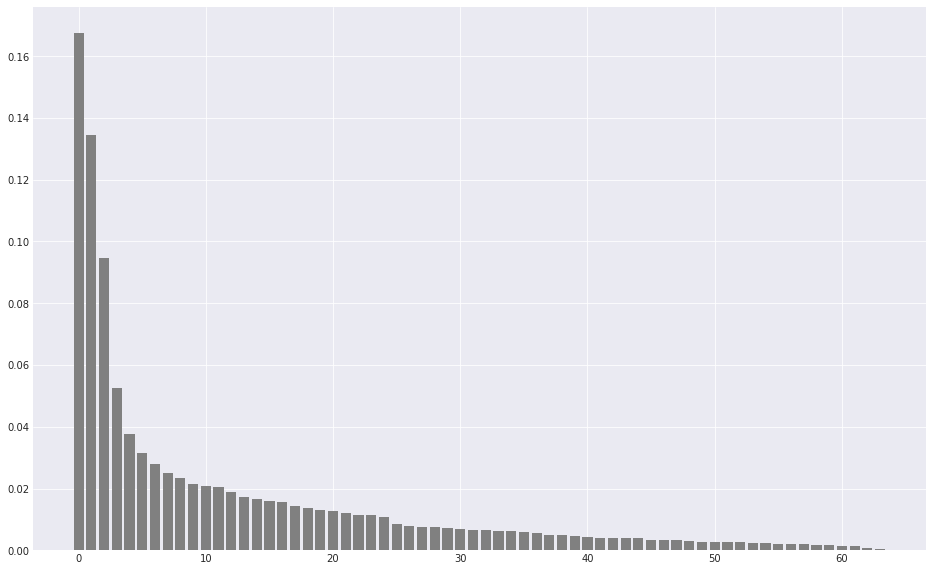

In [248]:
# Visually judge how much each component explains
sns.set_style(style='darkgrid')
x = np.arange(len(var_explained))
y = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(16,10))
plt.bar(x, y, color='grey');

In [261]:
# The first four components clearly stand out. How much variance do they explain?
var_explained[:4].sum()

44.93204116561342

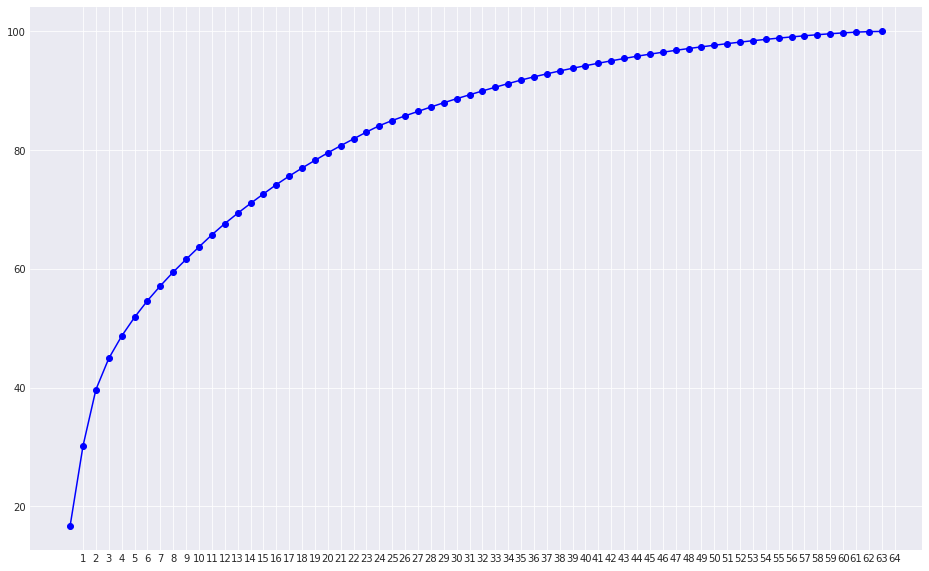

In [251]:
fig, ax = plt.subplots(figsize=(16,10))
plt.plot(np.cumsum(var_explained), marker='o', color='b')
ax.set_xticks(x+1, minor=False);

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=34)
pca.fit(data_imputed_scaled)
X_pca = pca.transform(data_imputed_scaled)
var_explained = pca.explained_variance_ratio_ * 100
print(var_explained.sum())

90.5893650133


In [273]:
# Dimensionality reduction
print(f'{100 - pca.n_components / len(data_imputed_scaled.columns) * 100:.2f}%')

46.88%


### Discussion 2.2: Perform Dimensionality Reduction

The visual exploration of the PCA results yielded no clear cut-off point. The first four components clearly stand out but only account for 44.93% of the variance. Every additional gradually explains less variance. So I decided that my cut-off point should be 90% explained variance. This is accomplished with 34 components resulting in a dimensionality reduction of 46.88%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [367]:
# Function for mapping PCA weights to column names
def map_pca_weights(pca, data, id_component=0):
    '''Map PCA weights to dataframe columns'''
    weights = pd.DataFrame(np.round(pca.components_, 4), columns=data.columns)
    component = weights.iloc[id_component, :]
    
    pos = component[component > 0].sort_values(ascending=True)
    neg = component[component < 0].sort_values(ascending=False)

    return neg, pos

def plot_weights(neg_weights, pos_weights):
    '''Plot negative and positive weights in opposing bar charts'''
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,10))
    neg_weights.plot.barh(ax=ax1, color='grey')
    pos_weights.plot.barh(ax=ax2, color='grey')
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    plt.legend = False
    plt.tight_layout();

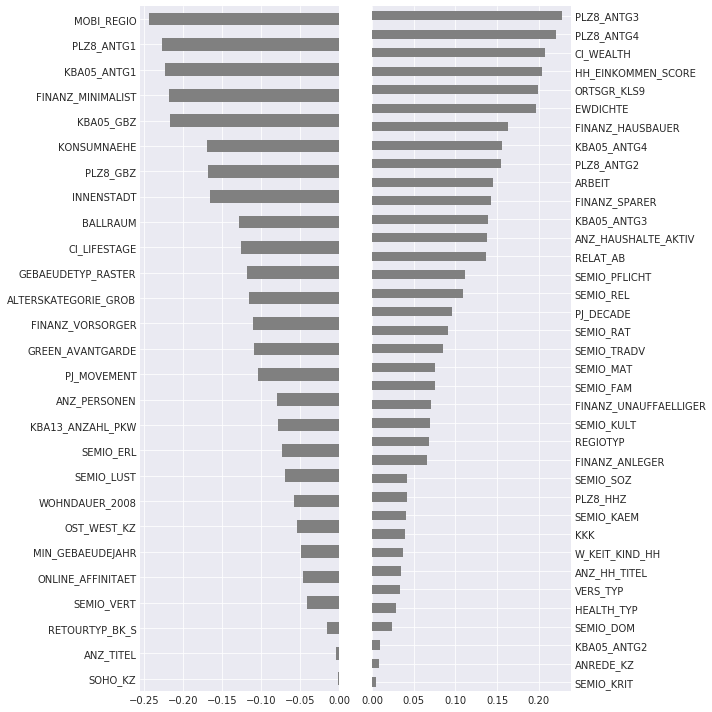

In [368]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = map_pca_weights(pca, data_imputed_scaled, id_component=0)
plot_weights(*weights)

**Top 5 negative weights**

1. MOBI_REGIO: Movement patterns in the region (high to low)
1. PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region (low to high)
1. KBA05_ANTG1: Number of 1-2 family houses in the microcell (low to high)
1. FINANZ_MINIMALIST: low financial interest (high to low)
1. KBA05_GBZ: Number of buildings in the microcell (few to many)

**Top 6 positive weights**

1. PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region (none to many)
1. PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region (none to many)
1. CI_WEALTH: wealth aspect of CAMEO_INTL_2015 (wealthy to poor)
1. HH_EINKOMMEN_SCORE: Estimated household net income (high to low)
1. ORTSGR_KLS9: Size of community (small to big)
1. EWDICHTE: Density of households per square kilometer (few to many)

**Interpretation**

The first principal component seems to be highly correlated with the density of people living in an area and low financial capacity.

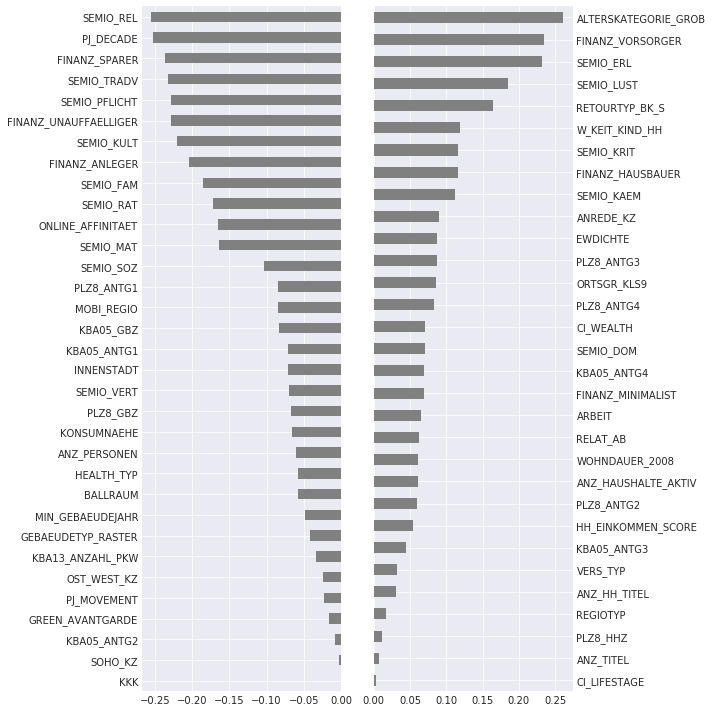

In [363]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = map_pca_weights(pca, data_imputed_scaled, id_component=1)
plot_weights(*weights)

**Top 7 negative weights**

1. SEMIO_REL: Religious personality typology (high to low affinity)
1. PJ_DECADE: Decade aspect of PRAEGENDE_JUGENDJAHRE (40s to 90s)
1. FINANZ_SPARER: Money-saver financial topology (high to low)
1. SEMIO_TRADV: Tradional-minded personality typology (high to low affinity)
1. SEMIO_PFLICHT: Dutiful personality typology (high to low affinity)
1. FINANZ_UNAUFFAELLIGER: Inconspicuous financial topology (high to low)
1. SEMIO_KULT: Cultural-minded personality typology (high to low affinity)

**Top 5 positive weights**

1. ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (young to old)
1. FINANZ_VORSORGER: "Be prepared" financial topology (high to low)
1. SEMIO_ERL: Event-oriented personality typology (high to low affinity)
1. SEMIO_LUST: Sensual-minded personality typology (high to low affinity)
1. RETOURTYP_BK_S: Return type (crazy shopper to minimal returner)

**Interpretation**

The second principal component emphasizes older people, traditional values and a frugal attitude. In essence it captures typical traits of the generation of our grandparents.

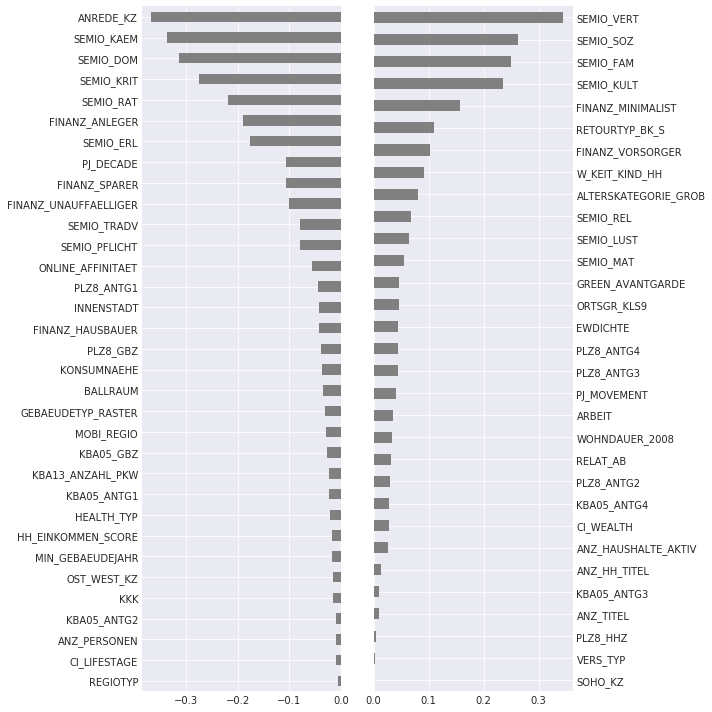

In [364]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = map_pca_weights(pca, data_imputed_scaled, id_component=2)
plot_weights(*weights)

**Top 5 negative weights**

1. ANREDE_KZ: gender (male, female)
1. SEMIO_KAEM: Combative attitude personality typology (high to low affinity)
1. SEMIO_DOM: Dominant-minded personality typology (high to low affinity)
1. SEMIO_KRIT: Critical-minded personality typology (high to low affinity)
1. SEMIO_RAT: Rational personality typology (high to low affinity)

**Top 5 positive weights**

1. SEMIO_VERT: Dreamful personality typology (high to low affinity)
1. SEMIO_SOZ: Socially-minded personality typology (high to low affinity)
1. SEMIO_FAM: Family-minded personality typology (high to low affinity)
1. SEMIO_KULT: Cultural-minded personality typology (high to low affinity)
1. FINANZ_MINIMALIST: low financial interest (high to low)

**Interpretation**

The third principal component seems to mainly capture typical gender traits, e.g. rational men and sympathetic women.

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Based on the interpretations above we can conclude the following:
* PC1: points towards people with low financial capacity living in densely populated areas with a low number of single-family buildings -> financial status (low values might also be a poverty indicator)
* PC2: points towards old people with a frugal attitude -> age and mindset / generation
* PC3: points towards people with "typical" masculine traits -> gender

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [391]:
# Over a number of different cluster counts...
scores = {}
for k in range(3, 15+1):
    # run k-means clustering on the data and...
    clf = KMeans(n_clusters=k, n_jobs=-1, random_state=42)
    clf.fit(X_pca)
    
    # compute the average within-cluster distances.
    scores[k] = abs(clf.score(X_pca))

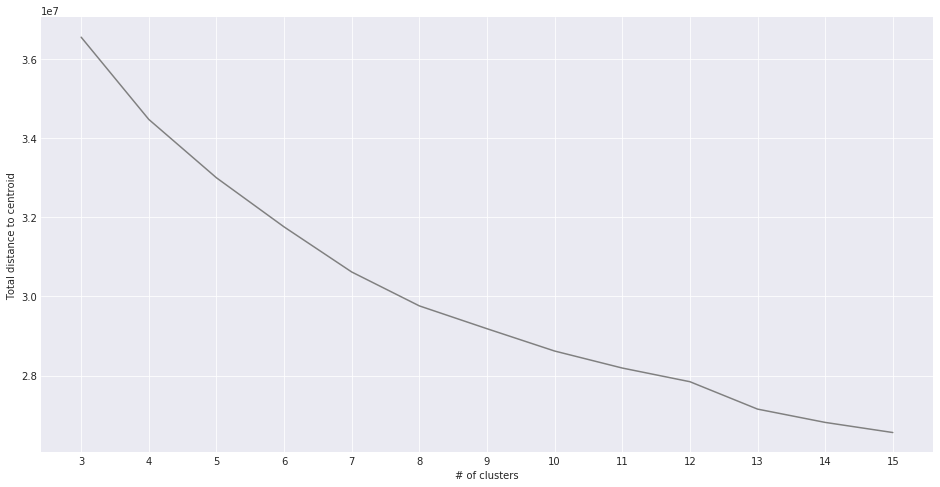

In [403]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots(figsize=(16,8))    
pd.Series(scores).plot(color='grey', ax=ax)
ax.set_xticks(np.arange(3, 15+1), minor=False);  
ax.set_xlabel("# of clusters")
ax.set_ylabel("Total distance to centroid");

In [51]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=8, n_jobs=-1, random_state=42)
kmeans.fit(X_pca)
y_predict = kmeans.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

Unfortunately the plotted curve does not have a clear "elbow". Possible candidates for the number of clusters are 4, 8, 13. I will proceed with 8 clusters as this number strikes a good balance with respect to the goal of differentiating between target groups.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [53]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_data = clean_data(customers)
customers_data[customers_data.columns] = imputer.transform(customers_data)
customers_data[customers_data.columns] = scaler.transform(customers_data)
customers_X_pca = pca.transform(customers_data)
customers_y_predict = kmeans.predict(customers_X_pca)

In [58]:
df = pd.DataFrame(customers_X_pca, columns=np.arange(1, 34+1)) 
df['cluster'] = customers_y_predict
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,cluster
0,-5.864712,0.856833,4.270290,2.225325,-3.122562,0.833468,-1.582971,-1.094122,0.477225,-0.299098,0.569261,1.049315,-0.989454,0.423933,-0.106611,0.775732,-0.106586,0.479727,0.191017,-0.233252,-0.415382,1.334539,-0.000033,-0.349431,0.123524,0.504385,-0.301723,0.531547,-0.201434,-1.214467,-0.742479,0.258310,-0.007989,-0.569061,2
1,-1.532846,4.892749,-0.649991,2.205482,0.971000,-0.857860,-0.173530,0.703020,-0.577784,-1.209061,0.197294,1.351843,0.181355,-1.189938,-1.049969,2.340968,0.078510,0.031140,-1.318641,-1.044940,-0.504926,-0.879518,-0.629784,0.536128,0.128082,0.453565,-0.132433,-1.245625,-0.224607,0.337407,-0.681454,-0.190354,-0.198798,0.461352,6
2,-4.432464,0.313028,2.693842,-2.377583,-0.911179,0.883445,-0.536312,0.862648,0.744260,-1.057760,0.575816,0.020062,-0.205119,-0.575287,0.138627,0.902720,-0.033312,-0.735228,0.318454,0.146378,1.787108,-0.584607,-0.238407,-0.062408,-0.207205,-0.802662,-0.295122,-0.414071,0.585082,0.902906,0.314163,-0.558517,-0.611074,0.158402,2
3,1.483945,-0.893494,1.176945,-0.649928,0.115051,-1.746485,1.481731,-0.973566,-0.418816,-1.232515,3.350622,-1.103013,0.416007,-0.132961,1.349358,0.838155,-0.150604,0.067077,0.281091,-0.976763,-0.935823,-0.006516,-0.795010,1.233434,-0.438013,0.531370,0.626707,-0.081857,0.630130,0.018197,-0.586667,0.115284,-0.073078,-0.217200,5
4,-2.364644,1.303081,2.857550,2.880601,-2.102361,-1.148129,0.337833,-0.007469,-1.046781,1.369291,-0.944361,-1.264907,0.443158,-0.726193,-2.077778,0.541295,0.004419,-1.377455,-0.544461,-0.318006,0.114960,-0.988811,0.044481,-0.022664,-1.272118,0.464641,-0.739305,-1.030386,-0.439067,0.007506,0.406076,0.335388,0.150369,-0.534978,2


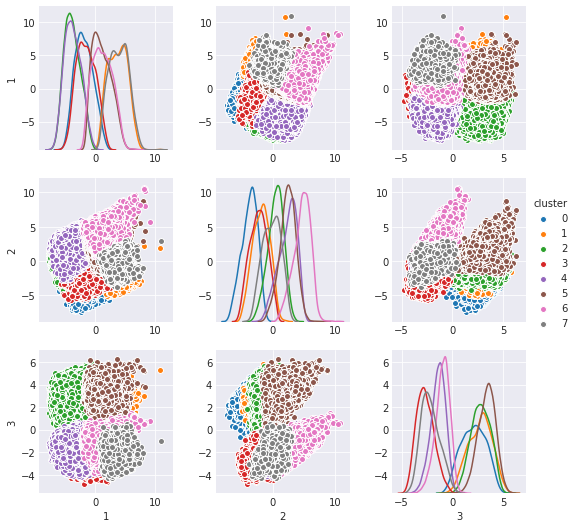

In [86]:
sns.pairplot(df, vars=np.arange(1, 3+1), diag_kind = 'kde', hue="cluster");

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

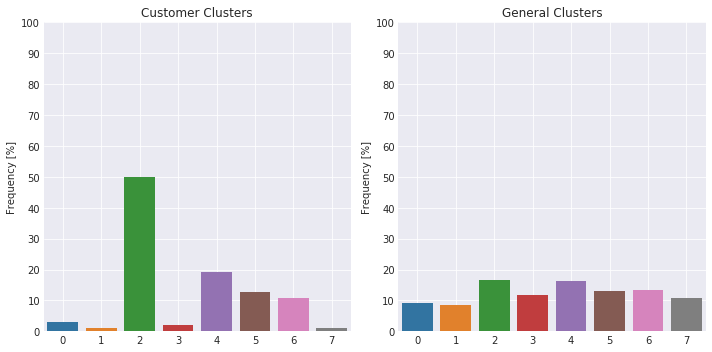

In [63]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.set_style('darkgrid')

fig, (ax11, ax21) = plt.subplots(ncols=2, figsize = (10,5))

ax12 = ax11.twinx()
ax22 = ax21.twinx()

sns.countplot(customers_y_predict, ax=ax12)
sns.countplot(y_predict, ax=ax22)

ax11.set_title('Customer Clusters')
ax11.set_ylim(0,100)
ax11.set_ylabel('Frequency [%]')
ax11.yaxis.set_major_locator(ticker.MultipleLocator(10))  # ensure a tick spacing of 10

ax12.set_ylim(0, customers_y_predict.shape[0])
ax12.set_ylabel('')
ax12.set_yticks([])
ax12.grid(None)

ax21.set_title('General Clusters')
ax21.set_ylim(0,100)
ax21.set_ylabel('Frequency [%]')
ax21.yaxis.set_major_locator(ticker.MultipleLocator(10))  # ensure a tick spacing of 10

ax22.set_ylim(0, y_predict.shape[0])
ax22.set_ylabel('')
ax22.set_yticks([])
ax22.grid(None)

plt.tight_layout();

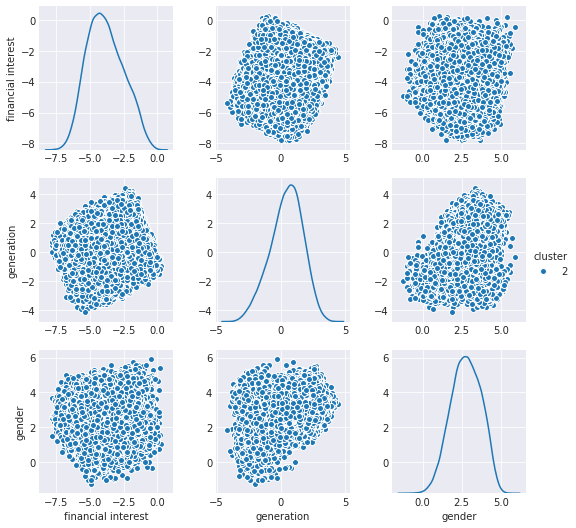

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
view = df[df['cluster'].isin([2])]
view = view.rename(columns = {1: 'financial interest', 2: 'generation', 3: 'gender'})

sns.pairplot(view, vars = ['financial interest', 'generation', 'gender'],
             diag_kind = 'kde', hue="cluster");

In [104]:
tmp = scaler.inverse_transform(customers_data)
tmp = pd.DataFrame(tmp, columns=customers_data.columns.tolist())
tmp[customers_y_predict == 2][['FINANZ_MINIMALIST', 'PJ_DECADE', 'ANREDE_KZ']].mean()

FINANZ_MINIMALIST    4.865214
PJ_DECADE            2.724697
ANREDE_KZ            1.000422
PLZ8_ANTG1           2.856567
dtype: float64

Cluster number 2 is highly overrepresented in the customer dataset. People in this cluster seem to be strongly correlated with negative values in principal component one (financial status / population density) which is confirmed by looking at the original data. The feature "low financial interest" as a low to very low typology rating. Thus people in this group do have a high financial interest. With regard to principal component two (generation) the values are clustered in the middle suggesting that middle-aged people are likely to belong to this group and again this theory can be confirmed. Principal component 3 shows a strong gender bias and a validation with the original data shows that nearly exclusively men belong into this cluster.

Summary: Customers are mainly middle-aged men with a high financial interest.

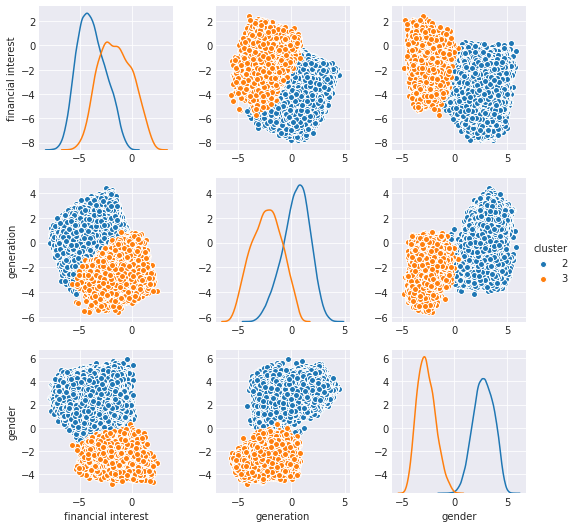

In [110]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Groups 0, 1, 3 and 7 are underrepresented in the customers dataset compared to the general population
view = df[df['cluster'].isin([2, 3])]
view = view.rename(columns = {1: 'financial interest', 2: 'generation', 3: 'gender'})

sns.pairplot(view, vars = ['financial interest', 'generation', 'gender'],
             diag_kind = 'kde', hue="cluster");

In [111]:
tmp = scaler.inverse_transform(customers_data)
tmp = pd.DataFrame(tmp, columns=customers_data.columns.tolist())
tmp[customers_y_predict == 3][['FINANZ_MINIMALIST', 'PJ_DECADE', 'ANREDE_KZ']].mean()

FINANZ_MINIMALIST    3.192595
PJ_DECADE            4.984336
ANREDE_KZ            1.978996
dtype: float64

People in cluster 3 are underrepresented in the customer dataset. They are nearly completely comprised of young women with an average financial interest.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

We excluded quite some data and skipped a few variables that could be included after preprocessing in another iteration. Despite this we were able to gain some meaningful insights about the customers. By far the most important customers of the mail-order company are middle-aged men with a high financial interest.

Young women with average financial interest in contrast are severly underrepresented as customers and could maybe be targeted with the right marketing tools.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.